In [1]:
from oggm import cfg, workflow, utils, shop
import pandas as pd
import os, glob
import numpy as np
import xarray as xr
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

In [9]:
f = f'../L3-L5_files/elev_bands/w5e5/qc0/pcpwin/test_default/RGI62/b_160/L5/summary/spinup_historical_run_output_11.nc'

In [10]:
ds = xr.open_dataset(f)

In [11]:
ds.volume.isel(time=-1).isnull().sum()

<xarray.DataArray 'volume' ()>
array(4)
Coordinates:
    time            float64 2.02e+03
    hydro_year      int64 ...
    hydro_month     int64 ...
    calendar_year   int64 ...
    calendar_month  int64 ...

In [12]:
ds.rgi_id.sel(rgi_id=ds.volume.isel(time=-1).isnull())

<xarray.DataArray 'rgi_id' (rgi_id: 4)>
array(['RGI60-11.01455', 'RGI60-11.03235', 'RGI60-11.03237', 'RGI60-11.03925'],
      dtype=object)
Coordinates:
  * rgi_id          (rgi_id) object 'RGI60-11.01455' ... 'RGI60-11.03925'
    time            float64 2.02e+03
    hydro_year      int64 ...
    hydro_month     int64 ...
    calendar_year   int64 ...
    calendar_month  int64 ...
Attributes:
    description:  RGI glacier identifier

In [6]:
f = f'../L3-L5_files/elev_bands/w5e5/qc0/pcpwin/test_default/RGI62/b_160/L5/summary/historical_run_output_11.nc'
ds = xr.open_dataset(f)
ds.volume.isel(time=-1).isnull().sum()

<xarray.DataArray 'volume' ()>
array(2)
Coordinates:
    time            float64 2.02e+03
    hydro_year      float64 ...
    hydro_month     float64 ...
    calendar_year   float64 ...
    calendar_month  float64 ...

In [8]:
ds.rgi_id.sel(rgi_id=ds.volume.isel(time=-1).isnull())

<xarray.DataArray 'rgi_id' (rgi_id: 2)>
array(['RGI60-11.03235', 'RGI60-11.03237'], dtype=object)
Coordinates:
  * rgi_id          (rgi_id) object 'RGI60-11.03235' 'RGI60-11.03237'
    time            float64 2.02e+03
    hydro_year      float64 ...
    hydro_month     float64 ...
    calendar_year   float64 ...
    calendar_month  float64 ...
Attributes:
    description:  RGI glacier identifier

In [159]:
v_spin = pd.DataFrame()
v_old = pd.DataFrame()

var = 'volume'
# var = 'area'

for reg in range(1, 20):
    f = f'../L3-L5_files/elev_bands/w5e5/qc0/pcpwin/test_default/RGI62/b_160/L5/summary/spinup_historical_run_output_{reg:02d}.nc'
    ds = xr.open_dataset(f)
    
    v = ds[var].load()
    is_null = ds.rgi_id.sel(rgi_id=v.isel(time=-1).isnull()).data
    
    f = f'../L3-L5_files/elev_bands/w5e5/qc0/pcpwin/test_default/RGI62/b_160/L5/summary/historical_run_output_extended_{reg:02d}.nc'
    
    ds = xr.open_dataset(f)
    v2 = ds[var].load()
    
    v.loc[dict(rgi_id=is_null)] = v2.sel(rgi_id=is_null, time=v.time)
    
    v_spin[f'{reg:02d}'] = v.sel(time=slice(2000, None)).sum(dim='rgi_id').to_series() * 1e-9
    v_old[f'{reg:02d}'] = v2.sel(time=slice(2000, None)).sum(dim='rgi_id').to_series() * 1e-9

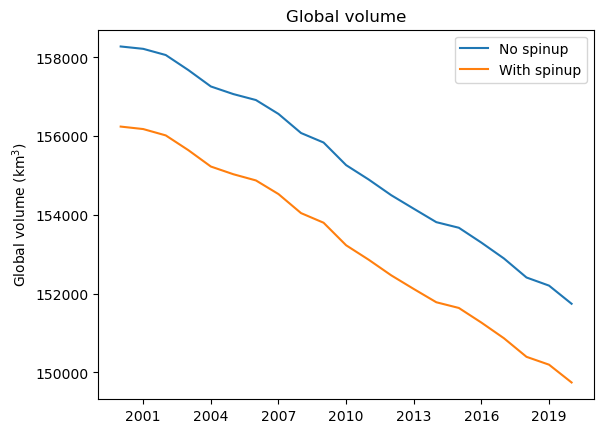

In [160]:
f, ax = plt.subplots()
v_old.sum(axis=1).plot(ax=ax, label='No spinup');
v_spin.sum(axis=1).plot(ax=ax, label='With spinup');
ax.set_ylabel('Global volume (km$^3$)'); ax.set_xlabel('');
ax.legend();
plt.title('Global volume');
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

In [161]:
dv_spin = (v_spin.iloc[1:] - v_spin.iloc[0:-1].values) * 0.9
dv_old = (v_old.iloc[1:] - v_old.iloc[0:-1].values) * 0.9

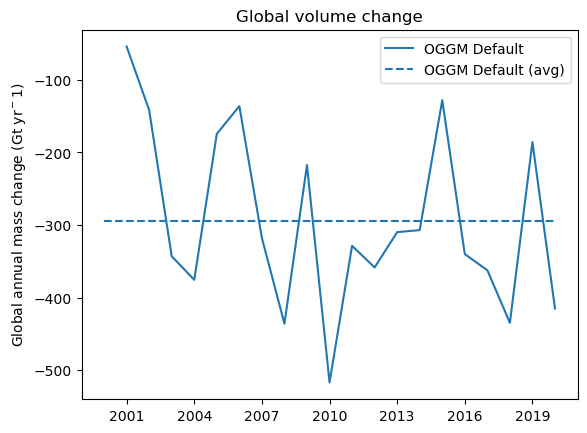

In [177]:
f, ax = plt.subplots()
dv_old.sum(axis=1).plot(ax=ax, label='OGGM Default');
# dv_spin.sum(axis=1).plot(ax=ax, label='With spinup');
# plt.hlines(-267, 2000, 2020, color='k', label='Hugonnet (avg)');
plt.title('Global volume change');
plt.hlines(dv_old.sum(axis=1).mean(), 2000, 2020, color='C0', linestyle='--', label='OGGM Default (avg)');
# plt.hlines(dv_spin.sum(axis=1).mean(), 2000, 2020, color='C1', linestyle='--', label='With spinup (avg)');
plt.legend();
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_ylabel('Global annual mass change (Gt yr$^-1}$)'); ax.set_xlabel('');

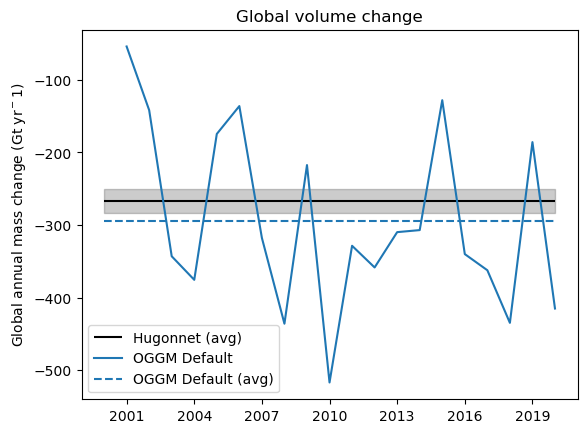

In [178]:
f, ax = plt.subplots()
# dv_spin.sum(axis=1).plot(ax=ax, label='With spinup');
plt.fill_between([2000, 2020], [-267+16, -267+16], [-267-16, -267-16], color='k', alpha=0.2);
plt.hlines(-267, 2000, 2020, color='k', label='Hugonnet (avg)');
dv_old.sum(axis=1).plot(ax=ax, label='OGGM Default');
plt.title('Global volume change');
plt.hlines(dv_old.sum(axis=1).mean(), 2000, 2020, color='C0', linestyle='--', label='OGGM Default (avg)');
# plt.hlines(dv_spin.sum(axis=1).mean(), 2000, 2020, color='C1', linestyle='--', label='With spinup (avg)');
plt.legend();
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_ylabel('Global annual mass change (Gt yr$^-1}$)'); ax.set_xlabel('');

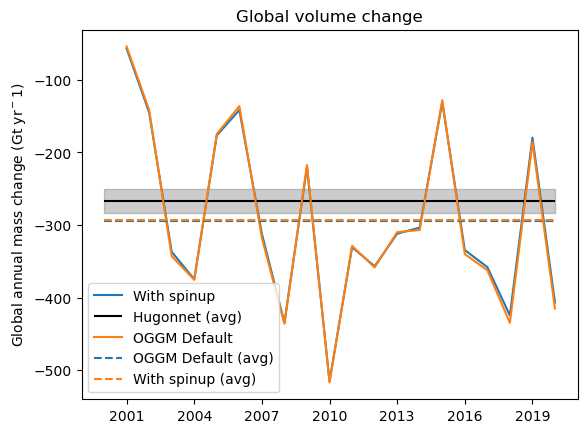

In [179]:
f, ax = plt.subplots()
dv_spin.sum(axis=1).plot(ax=ax, label='With spinup');
plt.fill_between([2000, 2020], [-267+16, -267+16], [-267-16, -267-16], color='k', alpha=0.2);
plt.hlines(-267, 2000, 2020, color='k', label='Hugonnet (avg)');
dv_old.sum(axis=1).plot(ax=ax, label='OGGM Default');
plt.title('Global volume change');
plt.hlines(dv_old.sum(axis=1).mean(), 2000, 2020, color='C0', linestyle='--', label='OGGM Default (avg)');
plt.hlines(dv_spin.sum(axis=1).mean(), 2000, 2020, color='C1', linestyle='--', label='With spinup (avg)');
plt.legend();
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_ylabel('Global annual mass change (Gt yr$^-1}$)'); ax.set_xlabel('');

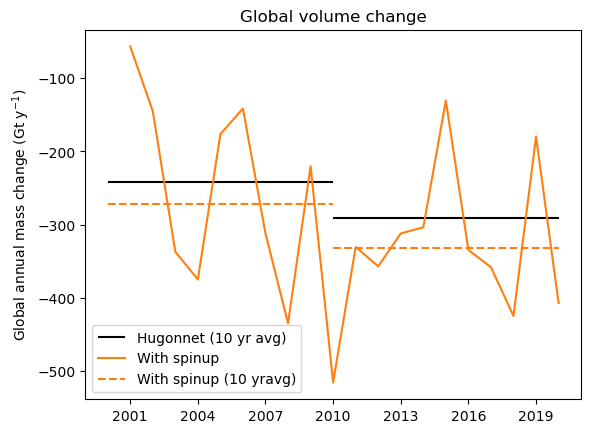

In [180]:
f, ax = plt.subplots()
# dv_old.sum(axis=1).plot(ax=ax, label='No spinup');
plt.hlines((-227 - 257)/2, 2000, 2010, color='k', label='Hugonnet (10 yr avg)');
plt.hlines((-285 - 298)/2, 2010, 2020, color='k');

dv_spin.sum(axis=1).plot(ax=ax, label='With spinup', color='C1');
plt.title('Global volume change');
plt.hlines(dv_spin.sum(axis=1).loc[:2010].mean(), 2000, 2010, color='C1', linestyle='--', label='With spinup (10 yravg)');
plt.hlines(dv_spin.sum(axis=1).loc[2010:].mean(), 2010, 2020, color='C1', linestyle='--');
plt.legend();
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_ylabel('Global annual mass change (Gt y$^{-1}$)'); ax.set_xlabel('');

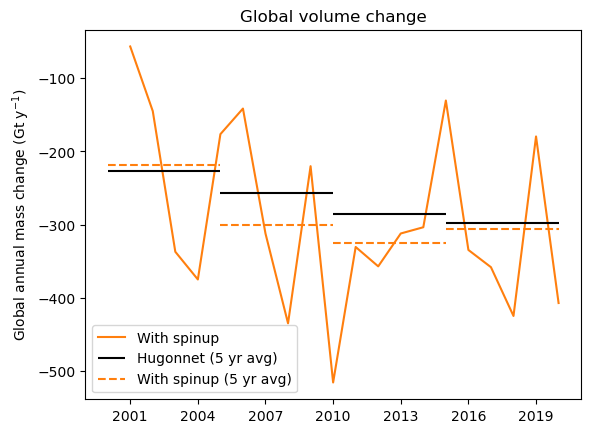

In [181]:
f, ax = plt.subplots()
# dv_old.sum(axis=1).plot(ax=ax, label='No spinup');
dv_spin.sum(axis=1).plot(ax=ax, label='With spinup', color='C1');
plt.hlines(-227, 2000, 2005, color='k', label='Hugonnet (5 yr avg)');
plt.hlines(-257, 2005, 2010, color='k');
plt.hlines(-285, 2010, 2015, color='k');
plt.hlines(-298, 2015, 2020, color='k');
plt.title('Global volume change');
plt.hlines(dv_spin.sum(axis=1).loc[:2005].mean(), 2000, 2005, color='C1', linestyle='--', label='With spinup (5 yr avg)');
plt.hlines(dv_spin.sum(axis=1).loc[2005:2010].mean(), 2005, 2010, color='C1', linestyle='--');
plt.hlines(dv_spin.sum(axis=1).loc[2010:2015].mean(), 2010, 2015, color='C1', linestyle='--');
plt.hlines(dv_spin.sum(axis=1).loc[2015:2020].mean(), 2015, 2020, color='C1', linestyle='--');
plt.legend();
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_ylabel('Global annual mass change (Gt y$^{-1}$)'); ax.set_xlabel('');

In [138]:
v_spin = pd.DataFrame()
v_old = pd.DataFrame()

# var = 'volume'
var = 'area'

for reg in range(1, 20):
    f = f'../L3-L5_files/elev_bands/w5e5/qc0/pcpwin/match_geod_pergla_dynspin/RGI62/b_160/L5/summary/spinup_historical_run_output_{reg:02d}.nc'
    ds = xr.open_dataset(f)
    
    v = ds[var].load()
    is_null = ds.rgi_id.sel(rgi_id=v.isel(time=-1).isnull()).data
    
    f = f'../L3-L5_files/elev_bands/w5e5/qc0/pcpwin/match_geod_pergla_dynspin/RGI62/b_160/L5/summary/historical_run_output_extended_{reg:02d}.nc'
    
    ds = xr.open_dataset(f)
    v2 = ds[var].load()
    
    v.loc[dict(rgi_id=is_null)] = v2.sel(rgi_id=is_null, time=v.time)
    
    v_spin[f'{reg:02d}'] = v.sel(time=slice(2000, None)).sum(dim='rgi_id').to_series() * 1e-6
    v_old[f'{reg:02d}'] = v2.sel(time=slice(2000, None)).sum(dim='rgi_id').to_series() * 1e-6

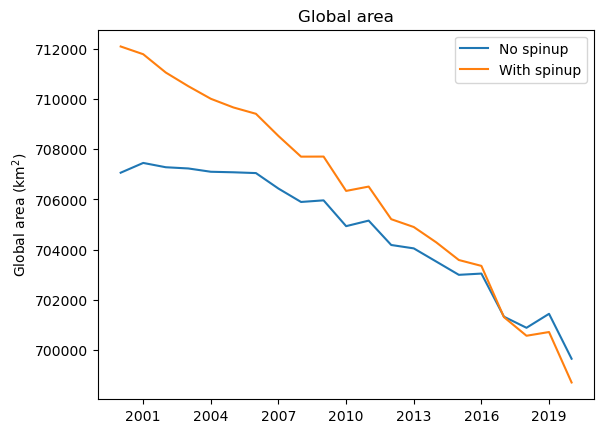

In [139]:
f, ax = plt.subplots()
v_old.sum(axis=1).plot(ax=ax, label='No spinup');
v_spin.sum(axis=1).plot(ax=ax, label='With spinup');
ax.set_ylabel('Global area (km$^2$)'); ax.set_xlabel('');
ax.legend();
plt.title('Global area');
ax.xaxis.set_major_locator(MaxNLocator(integer=True))